# 1.0 Read In Data

In [238]:
# Import libraries needed for linear regression computation
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
import scipy.stats as stats
import pylab 
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from operator import itemgetter
from sklearn.decomposition import PCA
%matplotlib inline

In [239]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)


Notice that the train data and the test data do not have the same number of columns. that is beacuse the train data has the SalePrice column.

# 2.0 EDA

First step is to view columns with null values. I will remove columns that have more than 90% of nulls. My gut feel is that fence is not a significant factor in determining house price so I will remove that column as well.

In [240]:
# View at nulls
null_cols = train_data.isnull().sum()
null_cols = pd.DataFrame(null_cols, columns=['count_null'])
null_cols = null_cols.sort_values(by='count_null', ascending=False)
null_cols['percent_null'] = null_cols['count_null']/train_data.shape[0]
null_cols = null_cols[null_cols['count_null'] > 0]

# Remove nulls > 90%
train_data = train_data.drop(columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'])

# Make a new null data dataframe
null_cols = train_data.isnull().sum()
null_cols = pd.DataFrame(null_cols, columns=['count_null'])
null_cols = null_cols.sort_values(by='count_null', ascending=False)
null_cols['percent_null'] = null_cols['count_null']/train_data.shape[0]
null_cols = null_cols[null_cols['count_null'] > 0]
null_cols

,count_null,percent_null
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479
GarageCond,81,0.055479
BsmtExposure,38,0.026027
BsmtFinType2,38,0.026027
BsmtQual,37,0.025342


View the data types of the null columns. Most of the columns are null because the house does not have that specific feature. For example, houses that do not have a garage will have a null values for all garage related columns such as GarageYrBlt. 

For numeric columns such as LotFrontage and MasVnrArea, nulls can be replaced with 0. For the object columns containing nulls, nan will be replaced with 'Not Available'.

In [241]:
# View the dtypes of the columns
null_data = train_data[null_cols.index]
print(null_data.dtypes)
print(null_data.head())

train_data['LotFrontage'] = train_data['LotFrontage'].fillna(0)
train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(0)

# Replace any null values in categorical variables with 'Not Available'
for i in train_data.columns:
    if train_data[i].dtypes == 'object':
        train_data[i] = train_data[i].fillna('Not_Available')

FireplaceQu      object
LotFrontage     float64
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
BsmtExposure     object
BsmtFinType2     object
BsmtQual         object
BsmtCond         object
BsmtFinType1     object
MasVnrArea      float64
MasVnrType       object
Electrical       object
dtype: object
  FireplaceQu  LotFrontage GarageType  GarageYrBlt GarageFinish GarageQual  \
0         NaN         65.0     Attchd       2003.0          RFn         TA   
1          TA         80.0     Attchd       1976.0          RFn         TA   
2          TA         68.0     Attchd       2001.0          RFn         TA   
3          Gd         60.0     Detchd       1998.0          Unf         TA   
4          TA         84.0     Attchd       2000.0          RFn         TA   

  GarageCond BsmtExposure BsmtFinType2 BsmtQual BsmtCond BsmtFinType1  \
0         TA           No          Unf       Gd       TA          GLQ   
1         T

Moving on to columns that are correlated with SalePrice

#### First let's take a look at all the numeric features and their correlation with SalePrice

In [242]:
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


Drop any features that have close to 0 (+- 5) correlation with SalePrice. Will keep BsmtHalf bath to combine with other bath columns

In [243]:
train_data = train_data.drop(columns=['YrSold', 'LowQualFinSF', 'MiscVal', 'BsmtFinSF2', '3SsnPorch', 'MoSold', 'Id'])

Combine the bath features and investigate if it leads to a better correlation. Based on the output below, the combination of the bath column leads to a corelation of 0.63!

In [244]:
train_data['NumBath'] = (train_data['FullBath'] + train_data['HalfBath']/2 + 
                       train_data['BsmtHalfBath']/2 + train_data['BsmtFullBath'])

train_data = train_data.drop(columns = ['FullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
NumBath,0.631731
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


Let's combine the 1st, 2nd and basement SF and investigate how it correlates with SalePrice. LivingSF has a 0.78 correlation with SalePrice. '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1' as they will have high correlation with LivingSF feature.

In [245]:
train_data['LivingSF'] = (train_data['1stFlrSF'].fillna(0) + train_data['2ndFlrSF'].fillna(0) 
                               + train_data['TotalBsmtSF'].fillna(0))

train_data = train_data.drop(columns = ['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
GarageCars,0.640409
NumBath,0.631731
GarageArea,0.623431
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


Let's combine the LotArea and LotFrontage features to determine if they will have a better correlation with SalePrice. TotalLotArea has a correlation of 0.26 which is slightly better than the individual correlations of LotArea and LotFrontage. Thus, LotArea and LotFrontage columns will be removed while keeping TotalLotArea

In [246]:
train_data['TotalLotArea'] = train_data['LotArea'] + train_data['LotFrontage']

train_data = train_data.drop(columns = ['LotArea', 'LotFrontage'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
GarageCars,0.640409
NumBath,0.631731
GarageArea,0.623431
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


Let's combine all the SF features that are outside of the house. For example, Garage, Porches, Pools etc that are not necessarily used for living. The addition of all the features give a correlation of 0.65. 

In [247]:
# combine total SF features outside
train_data['NonLivingSF'] = (train_data['EnclosedPorch'] + train_data['PoolArea'] + train_data['GarageArea'] + 
                             train_data['ScreenPorch'] + train_data['OpenPorchSF'] +  train_data['WoodDeckSF'])

train_data = train_data.drop(columns=['EnclosedPorch', 'PoolArea', 'GarageArea', 'ScreenPorch', 'OpenPorchSF', 'WoodDeckSF'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


The MSSubClass field should be seen as a categorical variable instead of a numeric

In [248]:
train_data['MSSubClassCat'] = train_data['MSSubClass'].astype('category')

train_data = train_data.drop(columns = ['MSSubClass'])

saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


Let's take a look at the KitchenAbvGr and OverallCond columns. Based on the plots, I will delete the KitchenAbvGr as there is a large variance with houses with one kitchen. OverallCond seems like it should have a positive correlation as well, however, due to the large variance with OverallCond of 5, there is a negative correlation. OverallCond column will be deleted as well

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


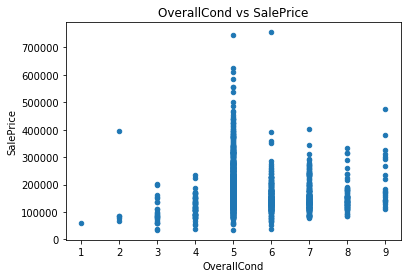

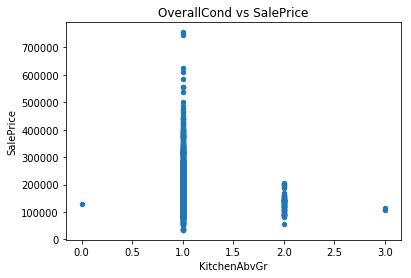

In [249]:
OverallCond_vs_SalePrice = train_data.plot(
    kind="scatter", x='OverallCond', y='SalePrice', title = "OverallCond vs SalePrice")

KitchenAbvGr_vs_SalePrice = train_data.plot(
    kind="scatter", x='KitchenAbvGr', y='SalePrice', title = "OverallCond vs SalePrice")

train_data = train_data.drop(columns = ['KitchenAbvGr', 'OverallCond'])

saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

Before we deal with features that are highly correlated with each other, let's take a look at the categorical variables. Below are all the categorical vairable columns

In [250]:
train_data.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

Delete BsmtFinType2 and BsmtFinType1 as their respective numeric features were dropped above

In [251]:
train_data = train_data.drop(columns= ['BsmtFinType1', 'BsmtFinType2'])

Let's change 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'GarageQual', 'GarageCond' to numeric vairables (similar to OverallCond)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
ExterQualInt,0.682639
KitchenQualInt,0.659600
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
BsmtQualInt,0.604816


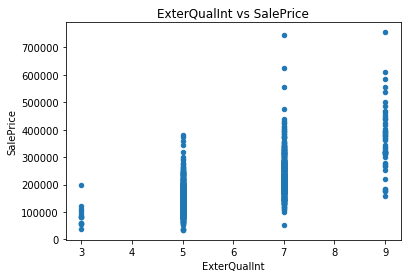

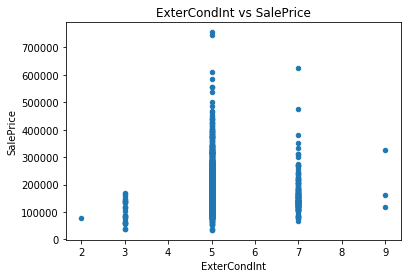

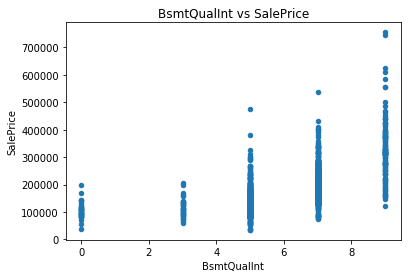

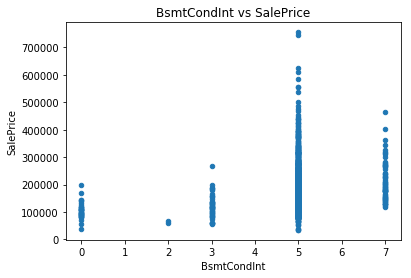

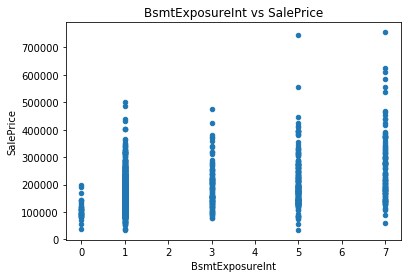

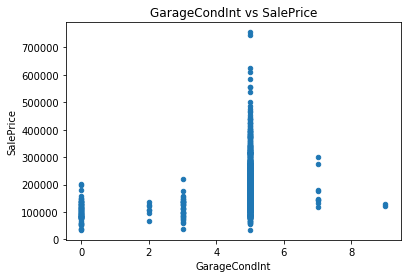

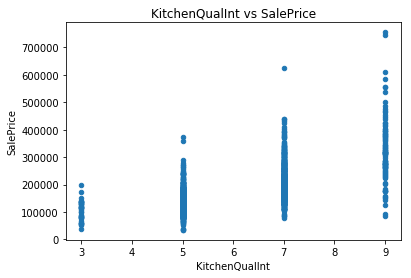

In [252]:
# Add int variables for ExterQual and ExterCond
train_data['ExterQualInt'] =  np.where(train_data['ExterQual'] == "Ex", 9, 
                                        np.where(train_data['ExterQual'] == "Gd", 7, 
                                                np.where(train_data['ExterQual'] == "TA", 5, 
                                                        np.where(train_data['ExterQual'] == "Fa", 3, 
                                                                np.where(train_data['ExterQual'] == "Po", 2,0)))))
train_data['ExterCondInt'] =  np.where(train_data['ExterCond'] == "Ex", 9, 
                                         np.where(train_data['ExterCond'] == "Gd", 7, 
                                                np.where(train_data['ExterCond'] == "TA", 5, 
                                                        np.where(train_data['ExterCond'] == "Fa", 3, 
                                                                np.where(train_data['ExterCond'] == "Po", 2,0)))))

# Add int variables for all categorical basement variables
train_data['BsmtQualInt'] =  np.where(train_data['BsmtQual'] == "Ex", 9, 
                                        np.where(train_data['BsmtQual'] == "Gd", 7, 
                                                np.where(train_data['BsmtQual'] == "TA", 5, 
                                                        np.where(train_data['BsmtQual'] == "Fa", 3, 
                                                                np.where(train_data['BsmtQual'] == "Po", 2,0)))))

train_data['BsmtCondInt'] =  np.where(train_data['BsmtCond'] == "Ex", 9, 
                                        np.where(train_data['BsmtCond'] == "Gd", 7, 
                                                np.where(train_data['BsmtCond'] == "TA", 5, 
                                                        np.where(train_data['BsmtCond'] == "Fa", 3, 
                                                                np.where(train_data['BsmtCond'] == "Po", 2,0)))))

train_data['BsmtExposureInt'] =  np.where(train_data['BsmtExposure'] == "Gd", 7, 
                                        np.where(train_data['BsmtExposure'] == "Av", 5, 
                                                np.where(train_data['BsmtExposure'] == "Mn", 3, 
                                                        np.where(train_data['BsmtExposure'] == "No", 1, 0))))

# Add int variables for GarageQual and GarageCond
train_data['GarageCondInt'] =  np.where(train_data['GarageCond'] == "Ex", 9, 
                                        np.where(train_data['GarageCond'] == "Gd", 7, 
                                                np.where(train_data['GarageCond'] == "TA", 5, 
                                                        np.where(train_data['GarageCond'] == "Fa", 3, 
                                                                np.where(train_data['GarageCond'] == "Po", 2,0)))))

train_data['GarageQualInt'] =  np.where(train_data['GarageQual'] == "Ex", 9, 
                                        np.where(train_data['GarageQual'] == "Gd", 7, 
                                                np.where(train_data['GarageQual'] == "TA", 5, 
                                                        np.where(train_data['GarageQual'] == "Fa", 3, 
                                                                np.where(train_data['GarageQual'] == "Po", 2,0)))))
# Add interaction variables for KitchenQual
train_data['KitchenQualInt'] =  np.where(train_data['KitchenQual'] == "Ex", 9, 
                                        np.where(train_data['KitchenQual'] == "Gd", 7, 
                                                np.where(train_data['KitchenQual'] == "TA", 5, 
                                                        np.where(train_data['KitchenQual'] == "Fa", 3, 
                                                                np.where(train_data['KitchenQual'] == "Po", 2,0)))))

train_data = train_data.drop(columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                                        'BsmtExposure', 'GarageCond', 'GarageQual', 'KitchenQual'])

ExterQualInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='ExterQualInt', y='SalePrice', title = "ExterQualInt vs SalePrice")
ExterCondInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='ExterCondInt', y='SalePrice', title = "ExterCondInt vs SalePrice")
BsmtQualInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='BsmtQualInt', y='SalePrice', title = "BsmtQualInt vs SalePrice")
BsmtCondInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='BsmtCondInt', y='SalePrice', title = "BsmtCondInt vs SalePrice")
BsmtExposureInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='BsmtExposureInt', y='SalePrice', title = "BsmtExposureInt vs SalePrice")
GarageCondInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='GarageCondInt', y='SalePrice', title = "GarageCondInt vs SalePrice")
KitchenQualInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='KitchenQualInt', y='SalePrice', title = "KitchenQualInt vs SalePrice")
                                        
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

Delete ExterCondInt as it has a correlation of almost 0. Based on the graphs, BsmtExposureInt, GarageCondInt and BsmtCondInt will be deleted as they visually do not have a clear linear relationship.

In [253]:
train_data = train_data.drop(columns= ['ExterCondInt', 'BsmtExposureInt', 'GarageCondInt', 'BsmtCondInt'])

Let's one hot encode the rest of the categorical variables and delete any features that have 'Not Available' present in the title

In [255]:
train_data = pd.get_dummies(train_data, drop_first=True)

print(train_data.shape)
# Delete any Not_Available columns (no use in the model)
train_data = train_data[train_data.columns.drop(list(train_data.filter(regex='Not_Available')))]

print(train_data.shape)

(1460, 201)
(1460, 196)


So far we have seen the correlation of all numeric variables with SalePrice. Next step is to see how all the numeric variable are corelated with each other.

From the heatmap below, (GrLivArea and LivingSF), (GarageYrBlt and YearBuilt), (OverallQual and LivingSF), (GarageCars and NonLivingSF) have a strong correlation with each other.

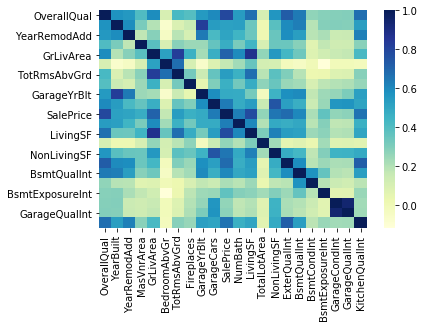

In [209]:
corr = train_data.corr()
sns.heatmap(corr, cmap="YlGnBu")

In [176]:
correlation_mat = train_data.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.60:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])
corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df

# https://onlinecourses.science.psu.edu/stat501/node/346/

,col1,col2,correlation
7,GrLivArea,LivingSF,0.874373
3,YearBuilt,GarageYrBlt,0.825667
5,GrLivArea,TotRmsAbvGrd,0.825489
1,OverallQual,SalePrice,0.790982
13,SalePrice,LivingSF,0.782260
11,GarageCars,NonLivingSF,0.747685
6,GrLivArea,SalePrice,0.708624
8,BedroomAbvGr,TotRmsAbvGrd,0.676620
9,TotRmsAbvGrd,LivingSF,0.672596
2,OverallQual,LivingSF,0.668155


In [ ]:
# Replace all Nan with not available

In [ ]:
# Get dummies

In [ ]:
# Delete the not available columns

In [ ]:
# Look at outliers

In [ ]:
# living SF

# Feature Enginerring

In [ ]:
# Feature Eng V1

# Linear Regression

In [ ]:
# Apply regulization and then add zeros to the feature engineering method

In [ ]:
# Try combining features and see if it makes the model better

# K-NN